In [1]:
library(dplyr)
library(tidyverse)
library(tidymodels)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ stringr 1.4.0
✔ tidyr   1.2.0     ✔ forcats 0.5.1
✔ readr   2.1.2     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales

In [96]:
# Read data into R
heart_disease_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE)

# Modify column names 
colnames(heart_disease_data) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num") 

# Modify datatypes
heart_disease_data <- heart_disease_data |>
    mutate(sex = as.factor(sex)) |>
    mutate(cp = as.factor(cp)) |>
    mutate(fbs = as.factor(fbs)) |>
    mutate(restecg = as.factor(restecg)) |>
    mutate(exang = as.factor(exang)) |>
    mutate(slope = as.factor(slope)) |>
    mutate(thal = as.factor(thal)) |>
    mutate(num = as.factor(num)) |>
    mutate(ca = as.factor(ca))

# Change "?" to NA
heart_disease_data[heart_disease_data == "?"] <- NA

head(heart_disease_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


Now we have successfully read the data, modified the column names and the datatype of each variable, we can split the dataset into the training and testing sets. (We changed the datatypes of several columns because these columns are either dummy or categorical variables; therefore we need to change them into factors)

In [97]:
set.seed(9999) 
heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = num)
heart_disease_training <- training(heart_disease_split)
heart_disease_testing <- testing(heart_disease_split)

We removed the columns that are dummy or categorical variables since these variables cannot be used in KNN classification model to predict the class, and we were left with 5 variables. Of these variables, we selected the 4 variables that we felt have the largest impact on heart disease.

In [98]:
selected_heart_disease_vars <- select(heart_disease_data, age, trestbps, chol, thalach, num)
head(selected_heart_disease_vars)

age,trestbps,chol,thalach,num
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,0
67,160,286,108,2
67,120,229,129,1
37,130,250,187,0
41,130,204,172,0
56,120,236,178,0


Then we can check for missing values:

In [101]:
selected_heart_disease_vars |> 
    filter(is.na(age) | is.na(trestbps) | is.na(chol) | is.na(thalach)| is.na(num))

age,trestbps,chol,thalach,num
<dbl>,<dbl>,<dbl>,<dbl>,<fct>


No missing values in the data.

Using the training data only, we can generate a summary table for the variable _num_.

In [29]:
heart_disease_training |> 
    group_by(num) |> 
    summarize(count = n())

num,count
<dbl>,<int>
0,122
1,41
2,27
3,27
4,8


Here we can see that _num_ is a categorical variables with 5 levels: value 0 indicates the absense of heart disease, values 1, 2, 3, 4 represent the presence with different levels. Looking at this table, we can have a rough idea of how people with/without heart disease are distributed. More than half of people do not have heart disease (122 people with 0 level num), and the rest, almost half of people do have heart disease(104 people with num = 1, 2, 3, or 4), with the level 1 being most common and level 4 being the least.

Plotting age vs trestbps and chol vs thalach:

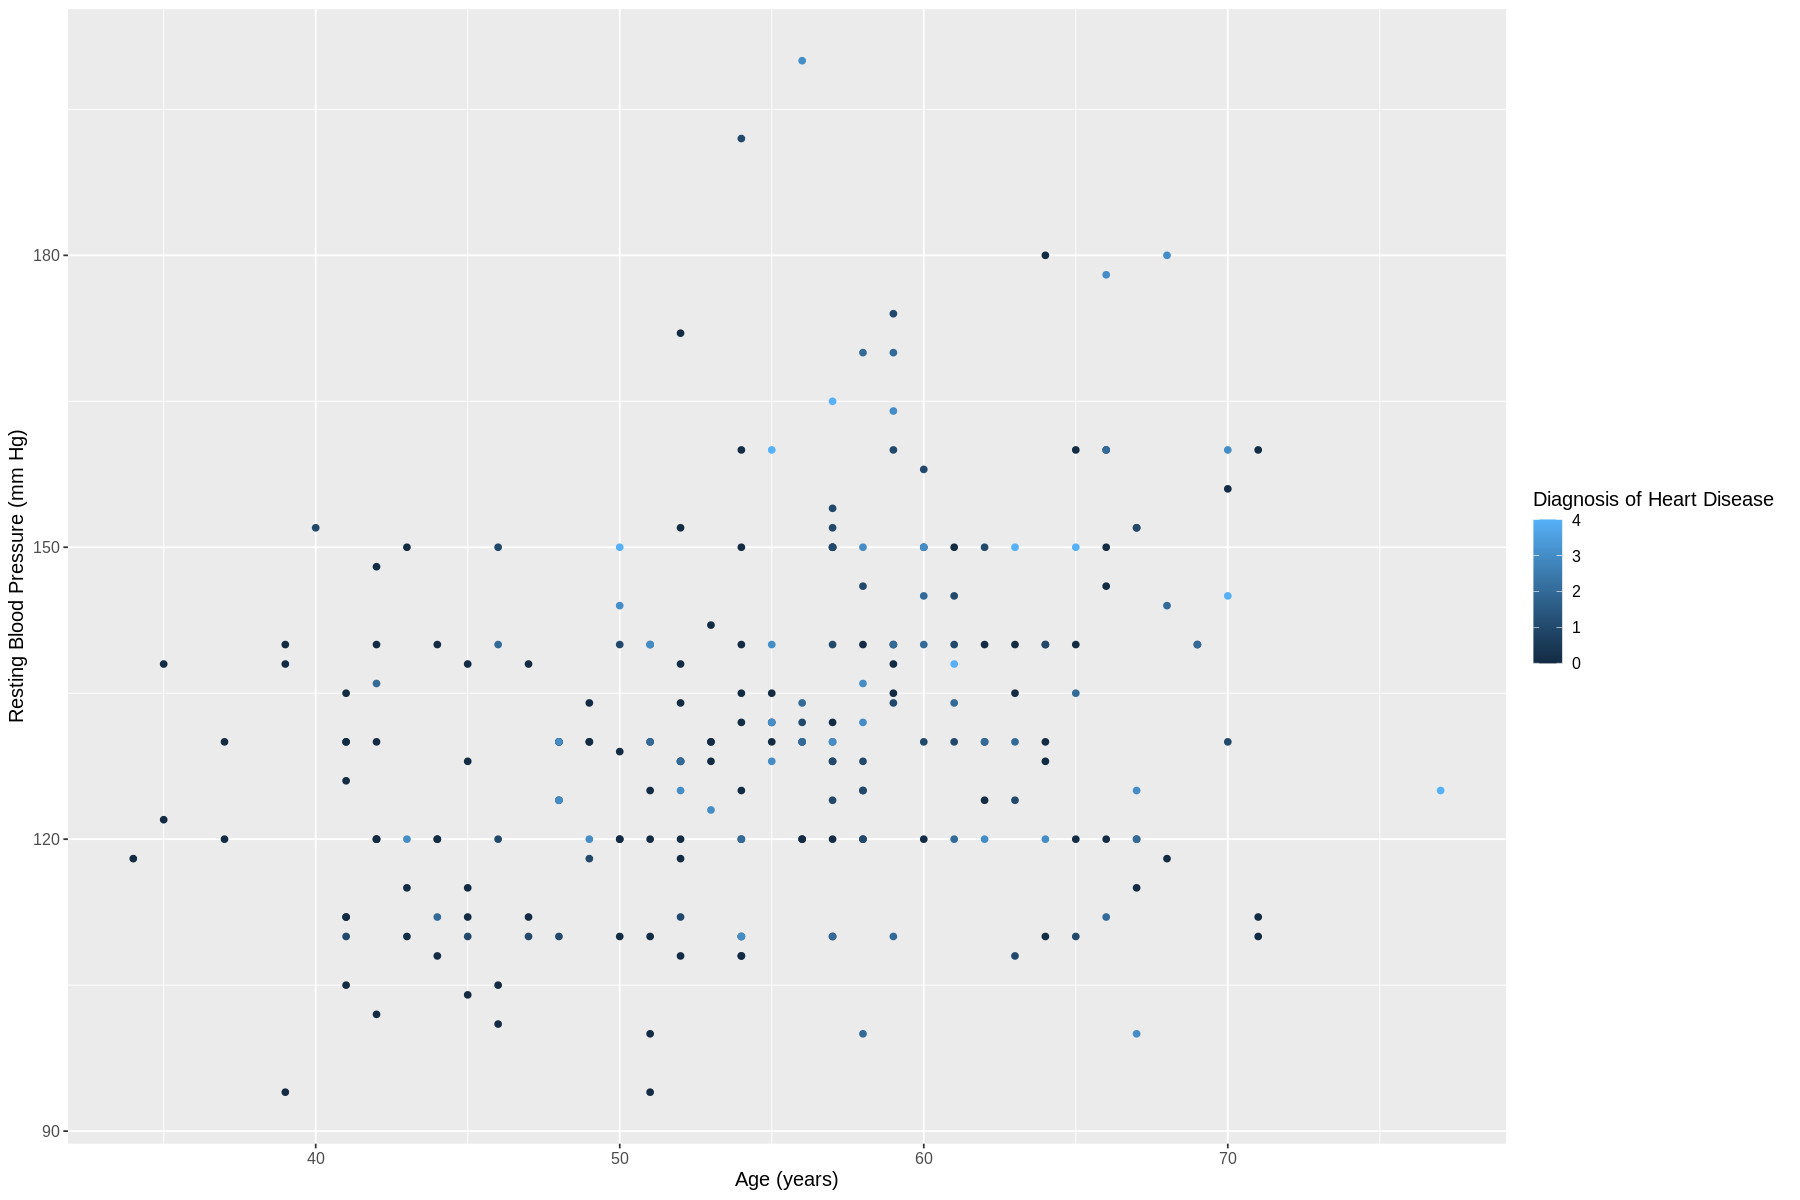

In [46]:
options(repr.plot.width = 15, repr.plot.height = 10)
heart_deasease_plot_1 <- heart_disease_training |> 
    ggplot(aes(x = age, y = trestbps, color = num)) +
    geom_point() +
    labs(x = "Age (years)", y = "Resting Blood Pressure (mm Hg)", color = "Diagnosis of Heart Disease") + 
    theme(text = element_text(size = 12))
heart_deasease_plot_1

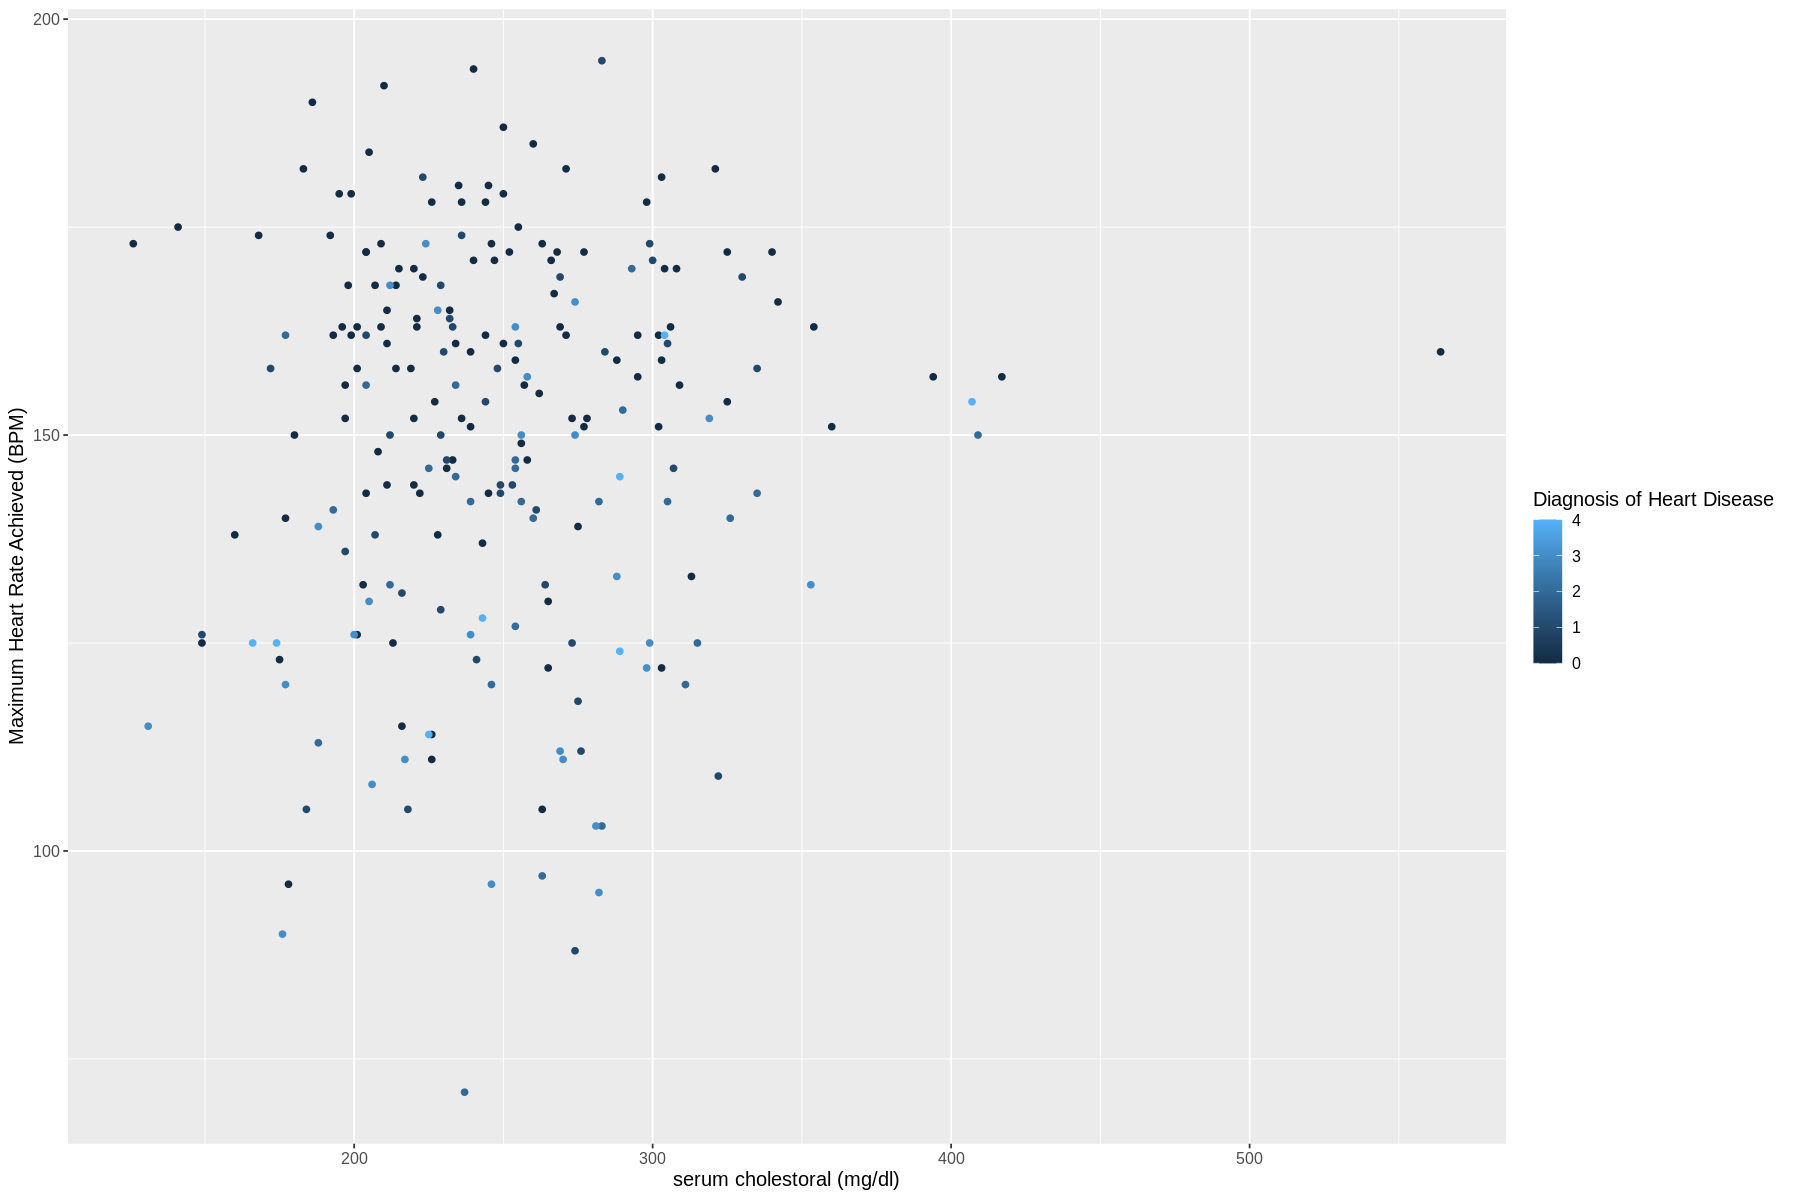

In [45]:
options(repr.plot.width = 15, repr.plot.height = 10)
heart_deasease_plot_2 <- heart_disease_training |> 
    ggplot(aes(x = chol, y = thalach, color = num)) +
    geom_point() +
    labs(x = "serum cholestoral (mg/dl)", y = "Maximum Heart Rate Achieved (BPM)", color = "Diagnosis of Heart Disease") + 
    theme(text = element_text(size = 12))
heart_deasease_plot_2